In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [12]:
df = pd.read_csv("UNSW_NB15.csv")

print("Dataset loaded successfully.")
print(f"Total Records: {df.shape[0]}")
print(f"Total Features: {df.shape[1]}")
df.head()

Dataset loaded successfully.
Total Records: 82332
Total Features: 45


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [13]:
# 1. Select Features
features = ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts']
X = df[features]
y = df['label'] # 0 = Normal, 1 = Attack

# 2. Scale Features (Important for Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for later use in the live app
joblib.dump(scaler, "model/scaler.pkl")
print("Scaler saved to model/scaler.pkl")

# 3. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Scaler saved to model/scaler.pkl
Training set size: (65865, 5)
Testing set size: (16467, 5)


In [14]:
# Dictionary of models to train
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "LogisticReg":  LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
}

print("Models defined:", list(models.keys()))

Models defined: ['RandomForest', 'DecisionTree', 'LogisticReg']


Starting training loop...

🔵 Training RandomForest...
✅ RandomForest Accuracy: 0.9310
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      7400
           1       0.95      0.93      0.94      9067

    accuracy                           0.93     16467
   macro avg       0.93      0.93      0.93     16467
weighted avg       0.93      0.93      0.93     16467

--------------------------------------------------
🔵 Training DecisionTree...
✅ DecisionTree Accuracy: 0.9251
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7400
           1       0.94      0.92      0.93      9067

    accuracy                           0.93     16467
   macro avg       0.92      0.93      0.92     16467
weighted avg       0.93      0.93      0.93     16467

--------------------------------------------------
🔵 Training LogisticReg...
✅ LogisticReg Accuracy: 0.6

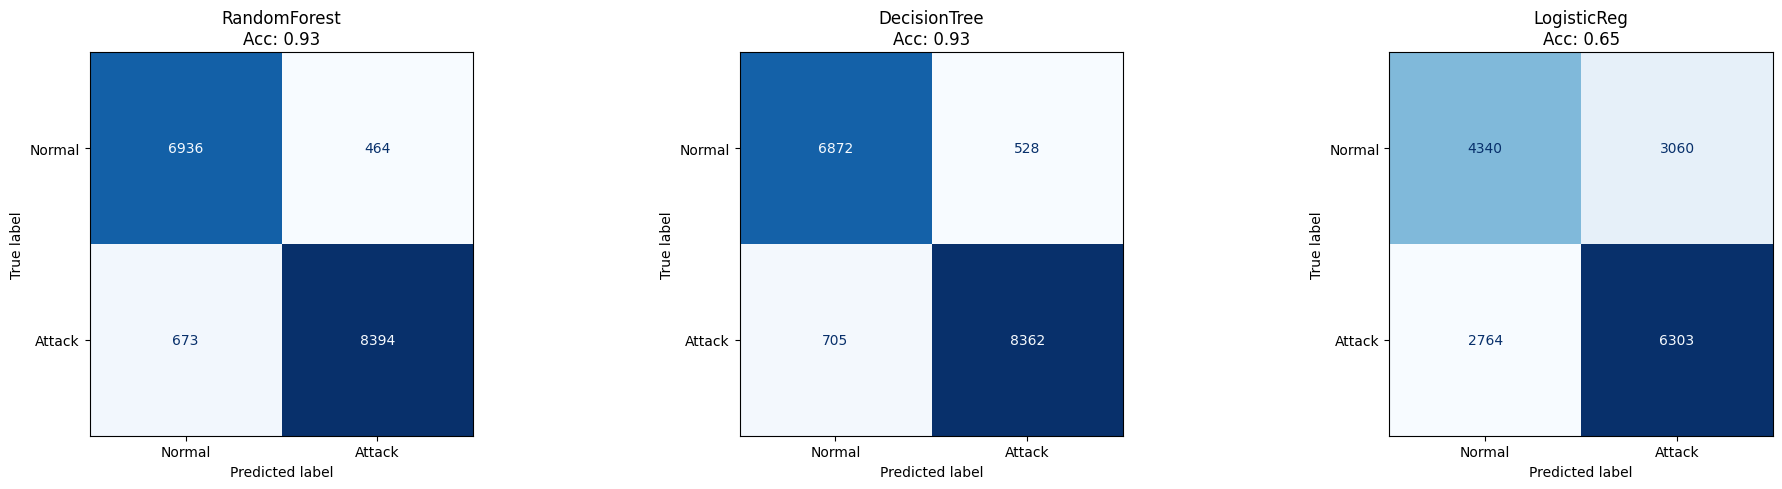


All models saved.


In [ ]:
results = {}

# Set up the matplotlib figure for side-by-side confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

print("Starting training loop...\n")

for i, (name, model) in enumerate(models.items()):
    print(f" Training {name}...")
    
    # 1. Train
    model.fit(X_train, y_train)
    
    # 2. Predict
    y_pred = model.predict(X_test)
    
    # 3. Calculate Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    # 4. Print Report
    print(f" {name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)
    
    # 5. Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}\nAcc: {acc:.2f}")
    
    # 6. Save Model
    joblib.dump(model, f"model/ids_model_{name.lower()}.pkl")

plt.tight_layout()
plt.show()
print("\nAll models saved.")

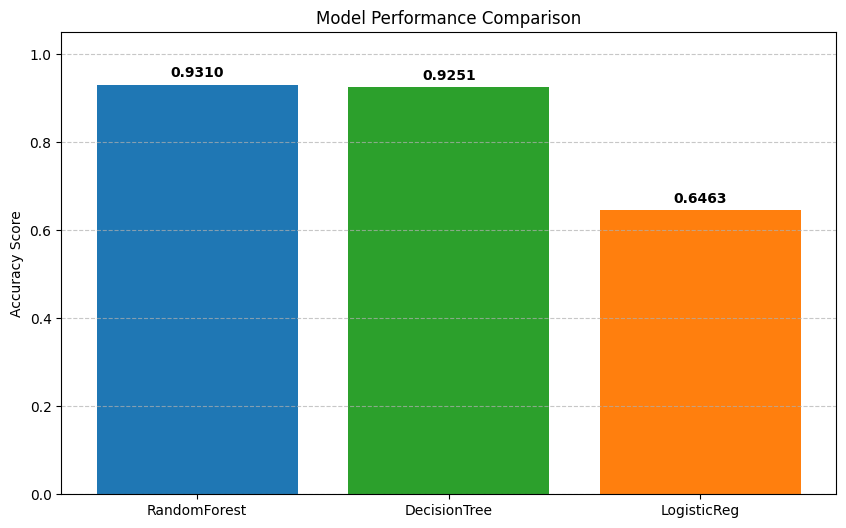

In [16]:
# Visualizing the accuracy comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['#1f77b4', '#2ca02c', '#ff7f0e'])

plt.ylim(0, 1.05)
plt.ylabel("Accuracy Score")
plt.title("Model Performance Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.show()